In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Linear Quadratic System and Variations

## 1. Base LQR

### 1.1 Formulation

The LQR system assumes following two conditions for $t = 1,2, ..., T$.

- **linear dynamical system**
$$x_t = Ax_t + Bu_t$$
    
- **quadratic cost function**
$$c(x_t, u_t) = {x_t}^\top Qx_t + {u_t}^\top Ru_t$$


We would like to solve the optimal control problem shown below.

$$\min_{x,u} \sum_{t=0}^{T-1} ({x_t}^\top  Q x_t + {u_t}^\top  R u_t) \\ \text{s.t. }x_{t+1} = A x_t + B u_t$$

*In the caes of the infinite horizon problem, $T$ is infinity*

In [20]:
x_dim = 4 # state dimension
u_dim = 3 # action dimension
A = np.random.randn(s_dim, s_dim)
B = np.random.randn(s_dim, a_dim)


# controllobility matrix
C = [B]
for i in range(4):
    C.append(A @ C[-1]) 
    
# check if the problem is controllable
assert np.linalg.matrix_rank(np.hstack(C)) == s_dim

Q = np.eye(s_dim)
R = np.eye(a_dim)

### 1.2 Solution with Value Iteration

We first define a cost-to-go function $J_i$ in order to find a optimal policy for a $i$-step horizon.

$$J_{i+1}(x) = \min_u[x^\top Qx + u^\top  Ru + J_i(Ax + Bu)]$$ 

Then, by setting the gradient w.r.t $u$ to zero, we get the following result.

for $i=1,2,3,...$

- **optimal policy**
    - $\pi(x) = K_{i}x$, where
      $$K_{i} = -(R + B^{\top} P_{i-1} B)^{-1} B^{\top} P_{i-1} A$$
    
    
- **quadratic cost function**
    - $J_i(x) = x^\top P_{i}x$, where
      $$P_i = Q + {K_i}^{\top}R K_i + (A + B K_i)^{\top} P_{i-1} (A + B K_i)$$
    
**$P_0 = 0$*

In [21]:
def lqr_infinite(A, B, Q, R, s_dim=4, a_dim=3, threshold=1e-4):
    P, K_current = np.eye(s_dim), np.zeros((a_dim, s_dim))
    while True:
        K_new = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A
        if np.linalg.norm(K_new - K_current) <= threshold:
            break
        else:
            K_current = K_new
            P = Q + K_current.T @ R @ K_current + (A + B @ K_current).T @ P @ (A + B @ K_current)
    return K_new, P

### 1.3 Experiment

In [22]:
Q, R = np.eye(s_dim), np.eye(a_dim) # better to do with psd & pd **
K_inf, P_inf = lqr_infinite(A, B, Q, R)

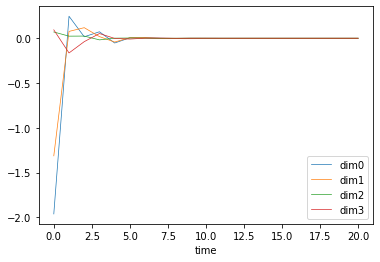

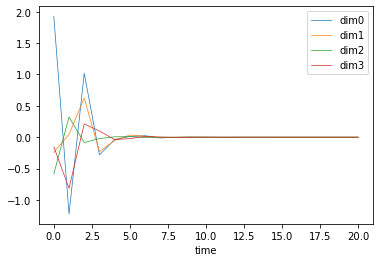

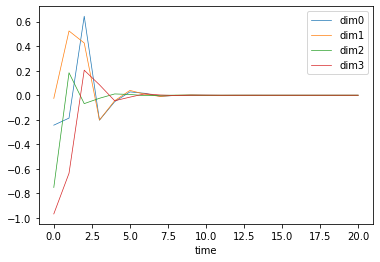

In [23]:
def simulate(A, B, K_inf, n_starting_states, T, noise=None):
    for s in np.arange(n_starting_states):
        x, u = np.zeros((K_inf.shape[1], T+1)), np.zeros((K_inf.shape[0], T+1))
        x[:,0] = starting_states[:,s]
        for t in np.arange(T):
            u[:,t] = K_inf @ x[:, t]
            x[:,t+1] = A @ x[:,t] + B @ u[:,t]
            if noise is not None:
                x[:,t+1] += noise[:,t]
        plt.plot(x.T, linewidth=.7)
        plt.xlabel('time')
        plt.legend(["dim"+str(i) for i in range(len(x))])
        plt.show()


starting_states = np.array([[-1.9613, 1.9277, -0.2442],
                            [-1.3127, -0.2406, -0.0260],
                            [0.0698, -0.5860, -0.7522],
                            [0.0935, -0.1524, -0.9680]])

n_starting_states = starting_states.shape[1]
T = 20 # simulating for 20 steps
simulate(A, B, K_inf, n_starting_states, T)



# write cost or l2 norm of x
# write unit (discrete) 

## 2. Linear Time Variant (LTV) LQR

### 2.1 Formulation

**write definition**

for $t = 1,2, ..., T$.

$$\min_{x,u} \sum_{t=1}^T (x_t^\top Q_t x_t + u_t^\top R_t u_t) + x_{T+1}^\top Q_{T} x_{T+1} \\ \text{s.t. }x_{t+1} = A_t x_t + B_t u_t$$

### 2.2 Solution with Value Iteration

In [33]:
def lqr_finite(A_lst, B_lst, Q_lst, R_lst, T):

    K_lst, P_lst= [], []
    s_dim, a_dim = A_lst[0].shape[0], B_lst[0].shape[1]
    
    P_lst.append(np.zeros((s_dim, s_dim)))
    K_lst.append(np.zeros((a_dim, s_dim)))

    for t in range(1, T+1):
        A = A_lst[T-t] if isinstance(A_lst, list) else A_lst
        B = B_lst[T-t] if isinstance(B_lst, list) else B_lst
        Q = Q_lst[T-t] if isinstance(Q_lst, list) else Q_lst
        R = R_lst[T-t] if isinstance(R_lst, list) else R_lst
        K_t = -np.linalg.inv(R + B.T @ P_lst[t-1] @ B) @ B.T @ P_lst[t-1] @ A
        P_t = Q + K_t.T @ R @ K_t + (A + B @ K_t).T @ P_lst[t-1] @ (A + B @ K_t)
        K_lst.append(K_t) 
        P_lst.append(P_t)
    
    K_lst = K_lst[1:]
    P_lst = P_lst[1:]
    
    return K_lst, P_lst

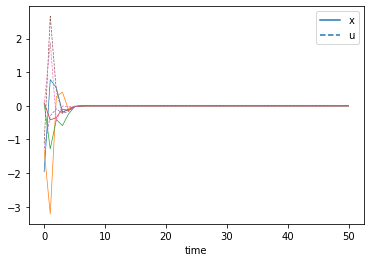

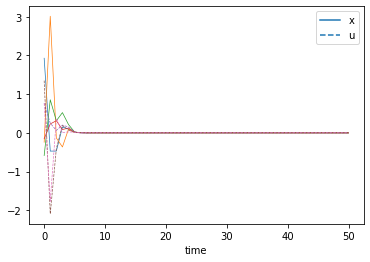

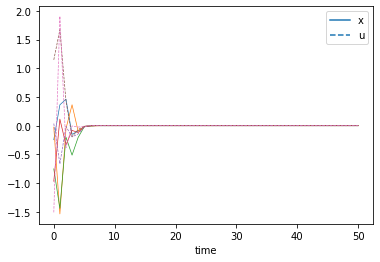

In [38]:
T = 50
A_lst = [np.array([[np.sin(t), -0.5049, 0.0299, 2.6544],
              [2.3846, -0.2312, -0.1260, -0.7945],
              [-0.0254, 0.4595, -0.0862, 2.1750],
              [0.5172, 0.5060, 1.6579, -0.9407]]) for t in range(T)]
B_lst = [np.array([[-0.7789, np.cos(t), -1.2076],
              [0.4299, -1.6041, np.sin(t)],
              [3*np.sin(t), 0.8302, 0.2295],
              [-1.8465, np.cos(t), 0.3241]]) for t in range(T)]

starting_states = np.array([[-1.9613, 1.9277, -0.2442],
                            [-1.3127, -0.2406, -0.0260],
                            [0.0698, -0.5860, -0.7522],
                            [0.0935, -0.1524, -0.9680]])
n_starting_states = starting_states.shape[1]

K_lst, P_lst = lqr_finite(A_lst, B_lst, Q, R, T)

def simulate(A_lst, B_lst, K_list, n_starting_states, T, noise=None):
    for s in np.arange(n_starting_states):
        x, u = np.zeros((K_list[0].shape[1], T+1)), np.zeros((K_list[0].shape[0], T+1))
        x[:,0] = starting_states[:,s]
        for t in np.arange(T):
            u[:,t] = K_lst[T-t-1] @ x[:,t]
            x[:,t+1] = A_lst[t] @ x[:,t] + B_lst[t] @ u[:,t]
            if noise is not None:
                x[:,t+1] += noise[:,t]
        plt.plot(x.T, linewidth=.7)
        plt.plot(np.squeeze(u.T), linewidth=.7, linestyle='--')
        legend_elements = [Line2D([0], [0], label='x'),Line2D([0], [0], linestyle='--', label='u')]
        plt.legend(handles=legend_elements)
        plt.xlabel('time')
        plt.show()

simulate(A_lst, B_lst, K_lst, n_starting_states, T)

## 3. Trajectory Following

### 3.1 Formulation

**define**

Given a feasible trajectory $\{ x_t, u_t\}_{t=0}^{H-1}$ , we define our optimization problem as follows:

$$\min_{u_0, ..., u_{H-1}} \sum_{t=0}^{H-1} (((x_t-x_t^*)\top Q_t (x_t-x_t^*) + (u_t-u_t^*)\top R_t (u_t-u_t^*))) \\ \text{s.t. }x_{t+1} = f(x_t, u_t)$$

**first LTV, then non-linear**

**say it on the math, saying q: psd, r: pd** 


lti, ltv - check answer to test my code.